In [2]:
using Gmsh
using Gridap
using GridapGmsh
using LinearAlgebra

Import the Mesh to a model and get the nodes and elements

In [3]:
model = GmshDiscreteModel("../data/VenturaAccelerometer/test_mesh_v2.msh")
nodes = model.grid.node_coordinates



Info    : Reading '../data/VenturaAccelerometer/test_mesh_v2.msh'...
Info    : 1 entity
Info    : 8 nodes
Info    : 6 elements
Info    : Done reading '../data/VenturaAccelerometer/test_mesh_v2.msh'


8-element Vector{VectorValue{2, Float64}}:
 VectorValue{2, Float64}(-1.0, 0.5)
  VectorValue{2, Float64}(0.0, 1.0)
 VectorValue{2, Float64}(-1.0, 1.0)
 VectorValue{2, Float64}(-1.0, 0.0)
  VectorValue{2, Float64}(0.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.5)
  VectorValue{2, Float64}(1.0, 1.0)

In [4]:
elements = model.grid.cell_node_ids

6-element Gridap.Arrays.Table{Int32, Vector{Int32}, Vector{Int32}}:
 [1, 2, 3]
 [1, 4, 5]
 [5, 6, 7]
 [1, 2, 5]
 [2, 5, 7]
 [2, 7, 8]

Get all the areas of the elements

In [5]:
Areas = zeros(length(elements))
A = 0
for (i, element) in enumerate(elements)
    area = 0
    for j in 1:length(element)
        k = j % length(element) + 1
        area += nodes[element[j]][1] * nodes[element[k]][2] - nodes[element[j]][2] * nodes[element[k]][1]
    end 
    Areas[i] = abs(area)/2  

end
println(Areas)
println(sum(Areas))
println(length)


[0.25, 0.25, 0.25, 0.5, 0.5, 0.25]


2.0
length


Define the F funtion

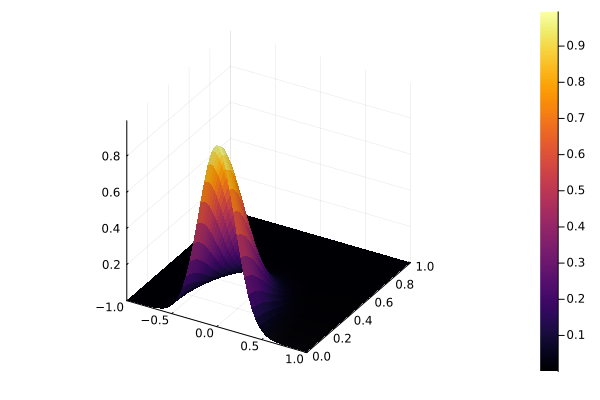

In [17]:
using Plots
function load(x, y, t)
    x0 = 0.0
    y0 = 0.0
    sigmax = 0.2
    sigmay = 0.2
    return exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))
    # return float(x == 0 && y == 0)
end

function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
    end

x = LinRange(-1,1,50)
y = LinRange(0, 1,50)

X,Y  = meshgrid(x,y)

fvalues = load.(X, Y, 0)

surface(X,Y,fvalues)


Compute the K matrix FINALLY

In [51]:
N = length(nodes)
Ke = zeros(3,3)
K = zeros(N,N)
F = zeros(N)
for (index,element) in enumerate(elements)
    COORDS = []
    for nd in element
        xi, yi= nodes[nd]
        COORDS = vcat(COORDS, [xi, yi, 1])
    end
    COORDS = transpose(reshape(COORDS, 3, 3))
    ABC = inv(float.(COORDS))

    for i in 1:3
        for j in 1:3
            Ke[i,j] = ABC[1,i]*ABC[1,j] + ABC[2, i]*ABC[2, j]
        end
    end

    Ke = Ke * Areas[index]

    for (local_i, real_i) in enumerate(element)
        for (local_j, real_j) in enumerate(element)
            K[real_i, real_j]+= Ke[local_i, local_j]
        end
    end

    # F, LOAD VECTOR
    for (local_i, global_i) in enumerate(element)
        fe = zeros(3)
        for (k,nd) in enumerate(element)
            xi,yi = nodes[nd]
            fe[k] = load(xi, yi, 0)
        end
        F[global_i] += fe[local_i] * Areas[index]/3
    end

end

display(K)
display(F)
# println(Areas[(2)])
# println(Areas[(3)])

8×8 Matrix{Float64}:
  2.5   -0.25  -1.0   -1.0   -0.25   0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 5.457923768636052e-8
 1.8633265860393389e-6
 1.1573286554136724e-12
 3.105544310065565e-7
 0.5
 3.105544310065565e-7
 5.457923768636052e-8
 1.1573286554136724e-12

#### Reduced Stiffness Matrix and Load Vector with Boundary Conditions

Let:

- ``BC_nodes``:vector with the local numbering of the nodes that have Dirichlet boundary conditions.

- ``BC_values``: vector of the values of the actual boundary conditions.

In [52]:
# Example that clamps the short edges of the plate, global nodes numbers: [1,3,4,6,7,8]

# BC_nodes  = [1,3,4,6,7,8]
# BC_values = [0,0,0,0,0,0]

BC_nodes  = [1]
BC_values = [0]

for i in 1:N
    if i in BC_nodes
        K[i,:] = zeros(N)
        K[i,i] = 1
        index = findfirst.(isequal.(i), (BC_nodes,))
        F[i] = BC_values[Int(index[1])]
    end
end
display(K)
display(F)


8×8 Matrix{Float64}:
  1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 0.0
 1.8633265860393389e-6
 1.1573286554136724e-12
 3.105544310065565e-7
 0.5
 3.105544310065565e-7
 5.457923768636052e-8
 1.1573286554136724e-12

## Simple `K*c=F` solution and plot

In [53]:
c = K\F

8-element Vector{Float64}:
 0.0
 0.4513917962830768
 0.09027835925754121
 0.13194512944138712
 0.6597244049892116
 0.5763918793047099
 0.5555584373291534
 0.5347251091208639

Create de M matrix

In [22]:
M = zeros(N,N)
for (index,element) in enumerate(elements)
    Me = I(3)
    Me = Me*Areas[index]/3
    #display(Me)
    for (local_i, real_i) in enumerate(element)
        M[real_i, real_i]+= Me[local_i, local_i]
    end
end
display(M)

8×8 Matrix{Float64}:
 0.333333  0.0  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.5  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0833333  0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0833333  0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.5  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0833333  0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.333333  0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.0       0.0833333

Damping Matrix

In [23]:
alpha = 0.1
beta  = 0.0
C = alpha * M + beta * K
display(C)

8×8 Matrix{Float64}:
 0.0333333  0.0   0.0         …  0.0         0.0        0.0
 0.0        0.05  0.0            0.0         0.0        0.0
 0.0        0.0   0.00833333     0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0         …  0.00833333  0.0        0.0
 0.0        0.0   0.0            0.0         0.0333333  0.0
 0.0        0.0   0.0            0.0         0.0        0.00833333